In [40]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import vgg19, resnet18
from torch import optim
from datasets import load_dataset

## Loading data

In [52]:
data = load_dataset('Abhijit85/InsuranceClaimImages')['train']
images = data['image']
img_size = len(images)
labels = data['label']  

## Analyzing data distribution

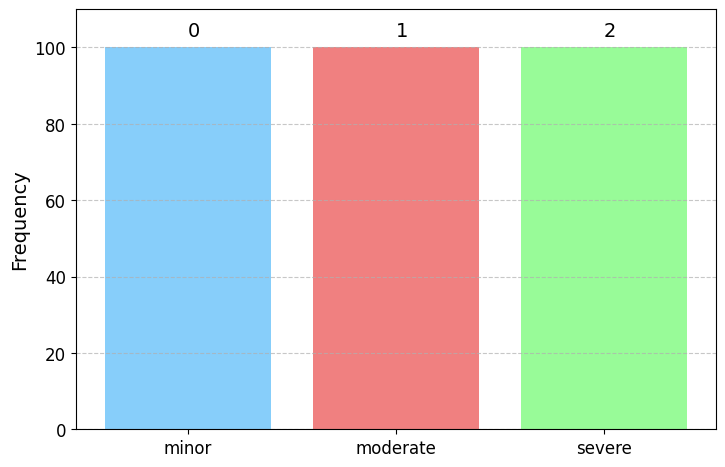

In [32]:
categories = ['minor', 'moderate', 'severe']
values = [0, 1, 2]
x_pos = np.arange(len(categories))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

colors = ['lightskyblue', 'lightcoral', 'palegreen']
lab, counts = np.unique(labels, return_counts=True)
ax.bar(lab, counts, color=colors, align='center')

ax.set_xticks(x_pos)
ax.set_xticklabels(categories, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel('Frequency', fontsize=14)
ax.grid(True, which='both', axis='y', linestyle='--', alpha=0.7)
ax.set_ylim([0, 110])

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)
for i in range(len(categories)):
        plt.text(i, counts[i] + 3, values[i], fontsize=14)

# Show the plot
plt.show()

# Image visualization

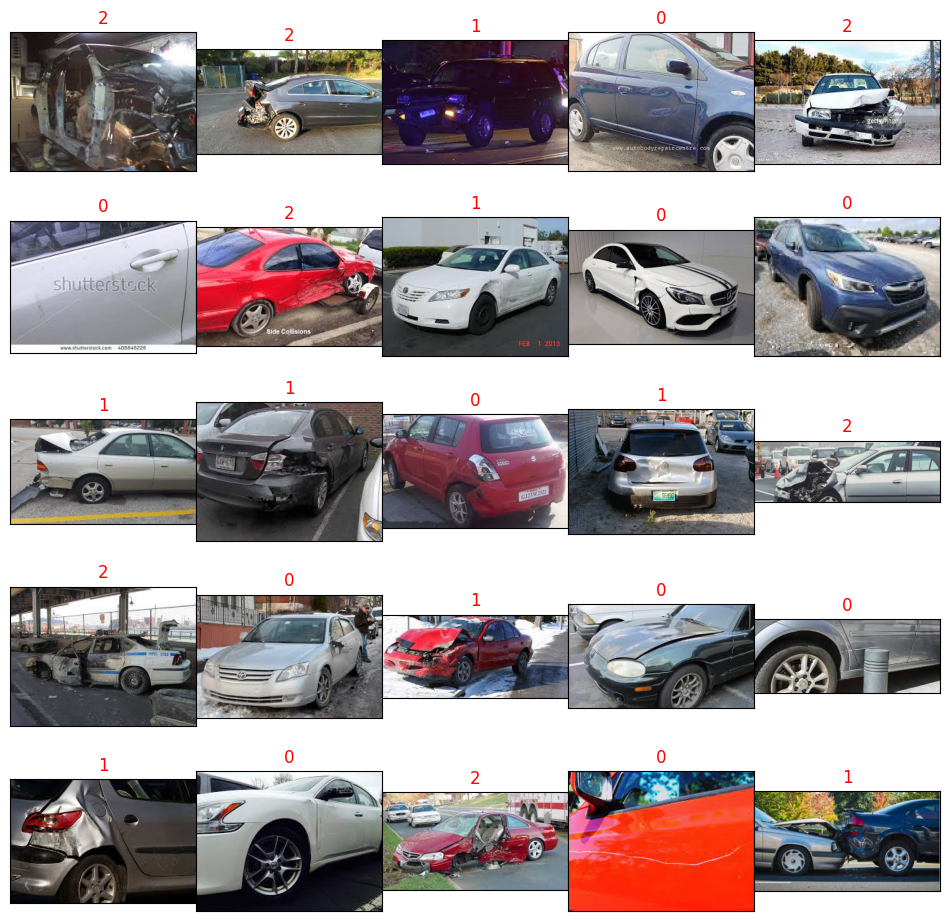

In [33]:
def plot_image_batch(image, labels, size=8, figsize=(12, 12)):
    rdn_idx = random.sample(range(len(image)), size * size)
    imgs = [image[i] for i in rdn_idx]
    titles = [labels[i] for i in rdn_idx]

    fig, ax = plt.subplots(size, size, figsize=figsize) 
    if isinstance(ax, np.ndarray):
        list_axes = list(ax.flat)
    else:
        list_axes = [ax]   
    for idx, img in enumerate(imgs):
        list_axes[idx].set_xticks([])
        list_axes[idx].set_yticks([])
        list_axes[idx].set_title(titles[idx], color='red')
        list_axes[idx].imshow(img)
    plt.subplots_adjust(wspace=0, hspace=0)    
    plt.show()

img_tranformed = []
for image in images:
    img_tranformed.append(image.convert("RGB"))
  
plot_image_batch(img_tranformed, labels, 5) 

# Data preprocessing

In [113]:
tr_size = int(0.9 * img_size) # Selecting 80% of data for training
batch_size = 32  # batch size
seed = 42

# Create train and test datasets
transformation = transforms.Compose([
    transforms.Resize(size=(128, 128), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])


class MyDataset(Dataset):

    def __init__(self, images, labels, transforms= None):
        super().__init__()
        self.images = images
        self.labels = labels
        self.transform = transforms

    def __len__(self):
        return len(self.images)    
    
    def __getitem__(self, idx):

        image = self.images[idx]
        label = self.labels[idx]

        if transforms:
            image = self.transform(image)

        return image, label    

# Extracting train and test indices
indices = list(range(len(data)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

# Transforming the data
train_subset = torch.utils.data.Subset(data, train_indices)
test_subset = torch.utils.data.Subset(data, test_indices)

def get_data_loader(seed, data, transform, batch=batch_size):
    torch.manual_seed(seed)
    images = data.dataset['image']
    labels = data.dataset['label']
    dataset = MyDataset(images, labels, transform)
    data_loader = DataLoader(dataset, batch_size=batch, shuffle=True)
    return data_loader

## Reproductibility test of dataloaders

All batches are identical


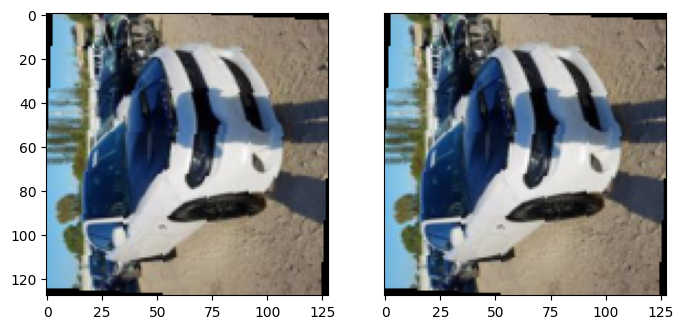

In [120]:
batches1, batches2 = [], []

for img, lab in get_data_loader(seed, train_subset, transformation):
    batches1.append(img.numpy())

# Collect batches from data_loader
for img, lab in get_data_loader(seed, train_subset, transformation):
    batches2.append(img.numpy())

# Compare
batches_identical = False
for b1, b2 in zip(batches1, batches2):
    if np.array_equal(b1, b2):
        batches_identical = True
        break

if batches_identical:
    print("All batches are identical")
else:
    print("Batches are not identical")

b1 = np.transpose(batches1[0][0], (2, 1, 0))
b2 = np.transpose(batches2[0][0], (2, 1, 0))

fig, ax = plt.subplots(1, 2, figsize=(8, 5))
ax[0].imshow(b1)
ax[1].imshow(b2)
ax[1].set_yticks([])
plt.show()

In [101]:
# Checking max and min values
values_tensor = []
for img, lab in get_data_loader(seed, train_subset, transformation):
    values_tensor.extend([img.max(), img.min()])

print(f'minima: {min(values_tensor)}, maximum: {max(values_tensor)}')    

minima: 0.0, maximum: 1.0


# Transfer learning

In [102]:
def train(model, tensor_data, optimizer, criteria, device='cpu'):
 
    loss_values = []
    for image, label in tensor_data:
        image = image.to(device)
        label = label.to(device)
        predict = model(image)
        loss = criteria(predict, label)
        loss_value = loss.detach().cpu()
        loss_values.append(loss_value.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    num_correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for image, label in tensor_data:
            image = image.to(device)
            label = label.to(device)    
            predict = model(image)
            _, score = predict.max(1)
            num_correct += (score == label).sum()
            total += score.size(0) 
        model.train()
    train_accuracy = num_correct * 100 / total

    return train_accuracy, loss_values      

def test(model, tensor_data, device='cpu'):
    
    num_correct = 0
    total = 0
    model.eval()
    probabilities, test_labels = [], []        
    with torch.no_grad():
        for image, label in tensor_data:
            test_labels.append(label)
            image = image.to(device=device)
            label = label.to(device=device)
            preds = model(image)
            prob = F.softmax(preds, dim=1)
            prob = prob.cpu()
            probabilities.append(prob.numpy())
            _, score = preds.max(1)
            num_correct += (score == label).sum()
            total += score.size(0)

    model.train()       
    accuracy = num_correct * 100 / total

    return accuracy, probabilities, test_labels

In [103]:
# Choosing model
model = resnet18(weights=True)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\danal\anaconda3\envs\cuda_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [121]:
# Different learning rates
lr1 = 1E-6  # For the convolutional layers
lr2 = 1E-3  # For the fully connected layer

# Adjusting output layer
model.fc = nn.Linear(model.fc.in_features, 3)

# To tune the whole layer
for param in model.parameters():
    param.requires_grad = True

conv_params = []
for name, param in model.named_parameters():
    if 'fc' in name:
        pass
    else:
        conv_params.append(param)

## For tunning only the last layer
#for param in model.fc.parameters():
#    param.requiers_grad = True

params_update = [
    {'params': conv_params, 'lr':lr1},
    {'params': model.fc.parameters(), 'lr':lr2}
]

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model.to(device)
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(params_update)
NUM_EPOCHS = 50


for epoch in range(NUM_EPOCHS):
    # epoch is added in order to get different image transformations
    train_data = get_data_loader(seed + epoch, train_subset, transformation)
    accuracy, loss = train(model, train_data, optimizer, criteria, device)
    if (epoch + 1) % 3 == 0:
        print(accuracy, "epoch: ", epoch + 1, "loss: ", np.mean(loss))

tensor(61.6667, device='cuda:0') epoch:  3 loss:  0.8998307824134827
tensor(70.3333, device='cuda:0') epoch:  6 loss:  0.7729528069496154
tensor(76.3333, device='cuda:0') epoch:  9 loss:  0.6689910590648651
tensor(79.3333, device='cuda:0') epoch:  12 loss:  0.6322052597999572
tensor(79.3333, device='cuda:0') epoch:  15 loss:  0.6111252874135971
tensor(82.6667, device='cuda:0') epoch:  18 loss:  0.5648866415023803
tensor(82.6667, device='cuda:0') epoch:  21 loss:  0.5277657598257065
tensor(86., device='cuda:0') epoch:  24 loss:  0.4723043590784073
tensor(86.6667, device='cuda:0') epoch:  27 loss:  0.5013098120689392
tensor(87., device='cuda:0') epoch:  30 loss:  0.4490790069103241
tensor(88.3333, device='cuda:0') epoch:  33 loss:  0.4508651465177536
tensor(89., device='cuda:0') epoch:  36 loss:  0.3710558533668518
tensor(89., device='cuda:0') epoch:  39 loss:  0.3363966703414917
tensor(91.3333, device='cuda:0') epoch:  42 loss:  0.3906248673796654
tensor(91., device='cuda:0') epoch:  45

## Confusion matrix

Average accuracy in the whole test data:
94.0


<Axes: >

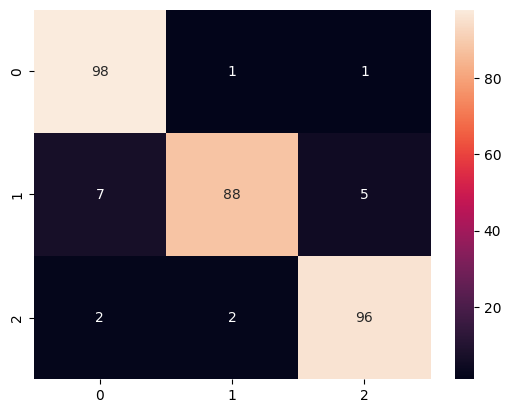

In [122]:
test_loader = get_data_loader(seed, test_subset, transformation, 1)
test_acc, probabilities, labels = test(model, test_loader, device)
print("Average accuracy in the whole test data:")
print(test_acc.item()) 

test_labels, pred_labels = [], []

# Appending the test labels
for label in labels:
    test_labels.append(label.item())  

# Getting the predicted label from the from the category with the highest probability
for prob in probabilities:
    pred_labels.append(np.argmax(prob))

cm = confusion_matrix(test_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='g')

## Checking misclassified images

9


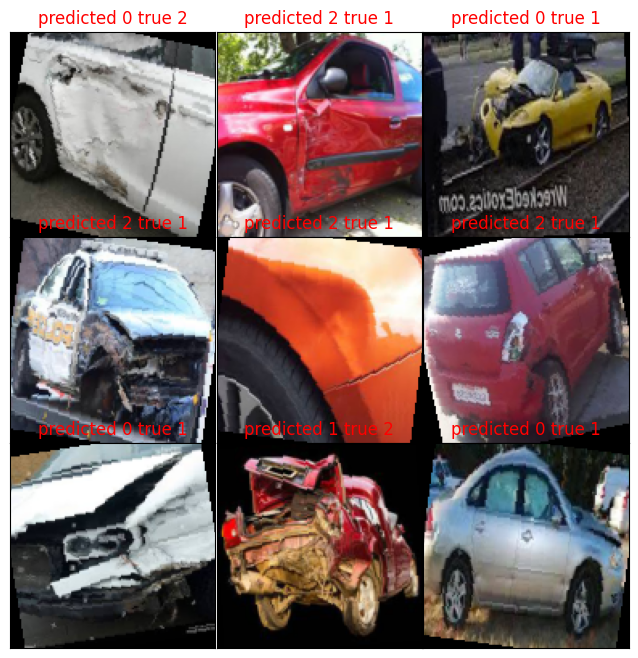

In [135]:
k = 0
wrong_labs = []
img_list = []
title = []

for img, label in test_loader:
    if test_labels[k] != pred_labels[k]:
        wrong_labs.append((pred_labels[k], test_labels[k]))
        img = img.detach().cpu()
        img_list.append(img.permute(0, 2, 3, 1).numpy()[0])#reshape(img.shape[1:]))
    k += 1

for i in range(9):
    label = wrong_labs[i]
    title.append("predicted " + str(label[0]) + " true " + str(label[1]))
print(len(img_list[:9]))  

plot_image_batch(img_list[:9], title, size=3, figsize=(8, 8))

# Saving the model and predicting pictures from the internet

In [136]:
torch.save(model, 'modelo.pth')

In [161]:
def predict(img):
    img = Image.open(img)
    transform = transforms.ToTensor()
    img = transform(img).unsqueeze(0)
    model = torch.load('model/modelo.pth', map_location='cpu')
    model.eval()
    probs_test = model(img)
    probs_test = probs_test.detach().cpu()
    return np.argmax(probs_test).item(), F.softmax(probs_test, 1)

pred_cpu, prob = predict('images/nivel1.jpg')
print(pred_cpu, *prob)

C:\Users\danal\AppData\Local\Temp\ipykernel_57064\3587881159.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('modelo.pth', map_location='cpu')


0 tensor([0.3563, 0.3392, 0.3046])


In [162]:
pred_cpu, prob = predict('images/nivel2.jpg')
print(pred_cpu, *prob)

2 tensor([0.3277, 0.3355, 0.3368])


C:\Users\danal\AppData\Local\Temp\ipykernel_57064\3587881159.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('modelo.pth', map_location='cpu')
